# Playing with lattice generation (i.e. generating non-cubic lattices)

140 0.6481481481481481


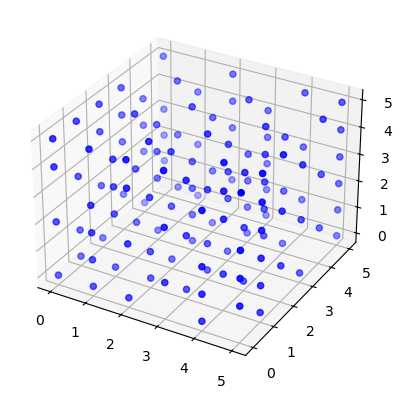

In [1]:
from math import ceil
import numpy as np
import matplotlib.pyplot as plt

from polymerist.maths.lattices import coordops
from polymerist.maths.lattices.integer import CubicIntegerLattice
from polymerist.maths.lattices.unitcell import COMMON_UNIT_LATTICE_VECTORS, LatticeParameters


max_n_atoms = 20_000
olig_size = 143

num_oligomers = ceil(max_n_atoms / olig_size)
d = ceil(num_oligomers**(1/3))

dims = np.array([d, d, d])
latt = CubicIntegerLattice(dims)
occupancy = num_oligomers / latt.capacity
stacked_points = np.vstack([latt.even_points, np.random.permutation(latt.odd_points)]) # first populate even points, and then odd points randomly into the "gaps"
oligomer_points = stacked_points[:num_oligomers]
print(num_oligomers, occupancy)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter( *oligomer_points.T, color='b')

## Generate Argon atom XYZ coordinates of reference unit vector transformed versions of an integer lattice

In [2]:
from pathlib import Path
from rdkit import Chem
from rdkit.Chem.AllChem import Compute2DCoords, EmbedMolecule
from rdkit.Geometry import Point3D


d = 4
dims = np.array([d, d, d])
latt = CubicIntegerLattice(dims)

aff = np.eye(4)
aff[:-1, -1] = 0.5
bound_points = CubicIntegerLattice(dims + 1).affine_transformation(aff)

bounds = coordops.bounding_box_dims(bound_points)
lower, upper = coordops.bounding_box_extrema(bound_points)

outdir = Path('lattices')
outdir.mkdir(exist_ok=True)
for name, lattice_vectors in COMMON_UNIT_LATTICE_VECTORS.items():
    lp = LatticeParameters.from_lattice_vectors(lattice_vectors)
    print(name, lp.lengths, lp.axial_angles(in_degrees=True), lp.volume)

    new_points = latt.points @ lattice_vectors.T
    contained_in_lattice = coordops.coords_inside_bbox(new_points, lower, upper, strict=False)
    outside_lattice = ~contained_in_lattice

    new_points = np.mod(new_points - lower, bounds)
    l_init = len(new_points)
    new_points = np.unique(new_points, axis=0)
    l_final = len(new_points)
    print(l_init - l_final)

    conf = Chem.Conformer()
    atom_smiles = []
    for i, point in enumerate(new_points):
        conf.SetAtomPosition(i, point.astype(float))
        atom_smiles.append('[Ar]')
    conf.Set3D(True)

    mol = Chem.MolFromSmiles('.'.join(atom_smiles))
    mol.AddConformer(conf)
    xyzpath = outdir / f'{name.lower()}.xyz'
    Chem.MolToXYZFile(mol, str(xyzpath))

CUBIC [1. 1. 1.] [90. 90. 90.] 1.0
0
HEXAGONAL [1. 1. 1.] [ 90.  90. 120.] 0.8660254037844384
0
RHOMBOHEDRAL [1. 1. 1.] [60. 60. 60.] 0.7071067811865471
0
RHOMBIC_DODECAHEDRON_XY_SQR [1. 1. 1.] [60. 60. 90.] 0.7071067811865474
0
TRUNCATED_OCTAHEDRON [1. 1. 1.] [ 70.52877937 109.47122063  70.52877937] 0.7698003589195008
0


## Development of Bravais-lattice-in-bouding-box calculation

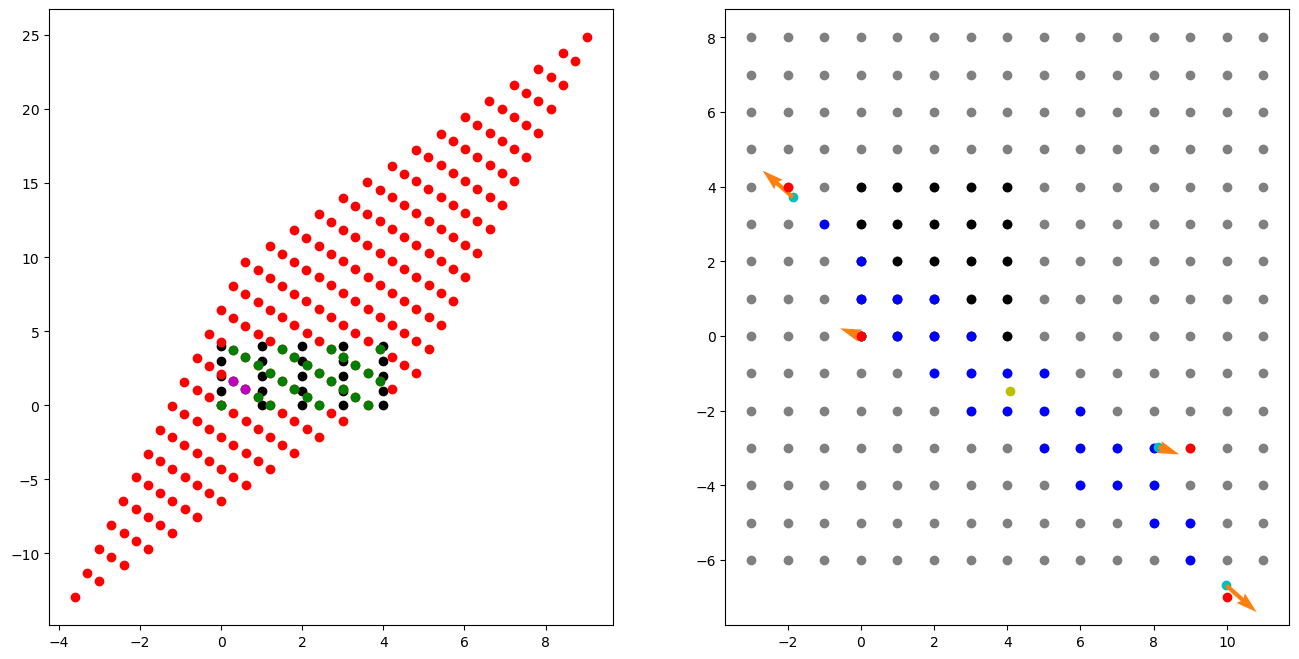

In [3]:
A = np.random.random((2,2)) * 2

scale = 3
dims = np.array([5, 5])
latt = CubicIntegerLattice(dims)
big_latt = CubicIntegerLattice(scale * dims)
translation = np.array([-3, -6])

latt_COM     = coordops.COM(latt.points)
big_latt_COM = coordops.COM(big_latt.points)
shear_COM = big_latt_COM @ A.T
# translation = np.zeros(2)
# translation = latt_COM - shear_COM
assert(translation.dtype == int)

# M = np.zeros((latt.n_dims+1, latt.n_dims+1))
# M[:latt.n_dims, :latt.n_dims] = A
# M[:-1, -1] = translation
# M[-1, -1] = 1
big_latt.points += translation
shear = big_latt.linear_transformation(A)

in_box = coordops.coords_inside_bbox(shear, *coordops.bounding_box_extrema(latt.points)).all(axis=1)
within = shear[in_box]
minset = within @ np.linalg.inv(A.T)
inv = coordops.bounding_box_points(latt.points) @ np.linalg.inv(A.T)

inv_COM = coordops.COM(inv)
int_bounds = np.vstack([
    coordops.nearest_int_coord_along_normal(pnt, pnt - inv_COM)
        for pnt in inv
])
directors = (inv - inv_COM)

s = 8
fig = plt.figure(figsize=(2*s, s))
ax  = fig.add_subplot(1,2,1)
ax.scatter(*latt.points.T, color='k')
ax.scatter(*shear.T      , color='r')
ax.scatter(*within.T     , color='g')
ax.scatter(*A            , color='m')

ax1  = fig.add_subplot(1,2,2)
ax1.scatter(*big_latt.points.T, color='gray')
ax1.scatter(*latt.points.T, color='k')
ax1.scatter(*minset.T     , color='b')
ax1.scatter(*inv.T        , color='c')
ax1.scatter(*inv_COM.T, color='y')
ax1.quiver(*inv.T, *directors.T, color=['tab:orange']*len(inv))
ax1.scatter(*int_bounds.T, color='r')

In [4]:
coord(int_bounds)

array([[ 0,  0],
       [-2,  4],
       [10, -7],
       [ 9, -3]])

# Playing with cubic/octahedral symmetry groups

In [ ]:
import numpy as np
from polymerist.graphics.plotutils import scatter_3D
from polymerist.maths.lattices import generate_int_lattice

d : int = 4

# produce integer lattice
dims = np.array([d, d, d])
num_points = dims.prod()
lattice = generate_int_lattice(*dims)

# sort lexicographically
order = np.lexsort(lattice.T)
lattice = lattice[order]

# determine even and odd positions after sorting
index_is_odd = lattice.sum(axis=1) % 2
index_is_odd = index_is_odd.astype(bool)

# center lattice at the origin
COM = lattice.mean(axis=0)
lattice = lattice - COM # sort lexicographically and translate center of grid to origin

# print(order, lattice[order])

In [ ]:
import matplotlib.pyplot as plt

alternate : bool = not False
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

if alternate:
    ax.scatter(*lattice[ index_is_odd].T, color='r')
    ax.scatter(*lattice[~index_is_odd].T, color='b')
else:
    ax.scatter(*lattice.T, color='r')

labels = np.lexsort(lattice.T)
for i, coords in zip(labels, lattice):
    ax.text(*coords, str(i))

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

In [ ]:
from typing import Generator, Iterable
from itertools import permutations, product as cartesian_product
from polymerist.maths.combinatorics.permutations import Permutation, Cycle
from scipy.spatial.transform import Rotation, Slerp


def sign_alternations(n : int) -> Generator[tuple[int, int, int], None, None]:
    '''Generate every possible n-tuple containing either 1 or -1'''
    for signs in cartesian_product(*([1, -1] for _ in range(n))):
        yield signs

def orthogonal_basis_transforms(n : int=3) -> Generator[np.ndarray, None, None]:
    '''Generate all matrices in n-dimensions which permute or invert the standard basis vectors'''
    for signs in sign_alternations(n):
        matr = np.diag(signs)
        for perm in Permutation.symmetric_group(n):
            yield matr @ perm.matrix

def interpolate_linear_transformation(trans : np.ndarray, n_frames : int=10) -> np.ndarray:
    '''Accepts a linear transformation matrix (of size MxN) and a number of frames F
    Returns an FxMxN array containing uniforms "steps" between the identity and the desired transformation'''
    I = Rotation.identity()
    rot = Rotation.from_matrix(trans)
    full_rot = Rotation.concatenate([I, rot])
    interpolator = Slerp(np.linspace(0, 1, num=len(full_rot), dtype=int), full_rot)

    return interpolator(np.linspace(0, 1, num=n_frames)).as_matrix()

In [ ]:
from collections import defaultdict

perms  = {}
all_cycles = {}

orbits = defaultdict(set)
stabilizers = defaultdict(list)

init_order = np.lexsort(lattice.T)
group_matrices = [el for el in orthogonal_basis_transforms(3)]
for i, trans in enumerate(group_matrices):
    new = lattice @ trans
    perms[i]      = perm   = Permutation(*np.lexsort(new.T))
    all_cycles[i] = cycles = perm.to_cycles(canonicalize=False)
    
    for cycle in cycles:
        if len(cycle) == 1:
            point_idx = cycle[0] # get the one element in the singleton cycle
            stabilizers[point_idx].append(trans)

        for point_idx in cycle:
            orbits[point_idx].update(cycle)

unique_orbits = set(tuple(sorted(orbit)) for orbit in orbits.values())
sum(len(i) for i in unique_orbits) == num_points

In [ ]:
stab_sizes = {k : len(v) for k, v in stabilizers.items()}
for i in unique_orbits:
    print([stab_sizes[j] for j in i])

## Visualize all symmetry actions as GIFs

In [ ]:
from pathlib import Path
from math import ceil
from matplotlib.animation import FuncAnimation, ArtistAnimation, writers
from rich.progress import track


n_frames = 20

dir = Path('gif_frames')
dir.mkdir(exist_ok=True)

ax_max = ceil(d / 2)
ax_min = -ax_max

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.autoscale(False)

def update(frame_no : int):
    partial_rot = keyframes[frame_no, :, :]
    latt_pos = lattice @ partial_rot

    ax.clear()
    ax.set(xlim3d=(ax_min, ax_max), xlabel='X')
    ax.set(ylim3d=(ax_min, ax_max), ylabel='Y')
    ax.set(zlim3d=(ax_min, ax_max), zlabel='Z')

    return ax.scatter(*latt_pos.T)

for i, trans in track(enumerate(group_matrices), total=len(group_matrices), description='Visualizing symmetry group actions...'):
    keyframes = interpolate_linear_transformation(trans, n_frames=n_frames)
    ani = FuncAnimation(fig=fig, func=update, frames=len(keyframes), interval=10)
    ani.save(dir/f'symmetry_{i+1}.gif', writer='pillow')
    plt.close(fig)

# Playing with rich progress

In [ ]:
from rich.progress import track, Progress
from time import sleep

with Progress() as progress:

    task1 = progress.add_task("[red]Downloading...", total=1000)
    task2 = progress.add_task("[green]Processing...", total=1000)
    task3 = progress.add_task("[cyan]Cooking...", total=1000)

    while not progress.finished:
        progress.update(task1, advance=0.5)
        progress.update(task2, advance=0.3)
        progress.update(task3, advance=0.9)
        sleep(0.02)

In [ ]:
import time
import random
from rich.progress import (
    BarColumn,
    Progress,
    SpinnerColumn,
    TaskProgressColumn,
    TimeElapsedColumn,
    TimeRemainingColumn,
)

def process(chunks):
    for chunk in chunks:
        time.sleep(0.1)
        yield chunk

chunks = [random.randint(1,20) for _ in range(100)]

progress_columns = (
    SpinnerColumn(),
    "[progress.description]{task.description}",
    BarColumn(),
    TaskProgressColumn(),
    "Elapsed:",
    TimeElapsedColumn(),
    "Remaining:",
    TimeRemainingColumn(),
)

with Progress(*progress_columns) as progress_bar:
    task = progress_bar.add_task("[blue]Downloading...", total=sum(chunks))
    for chunk in process(chunks):
        progress_bar.update(task, advance=chunk)

In [ ]:
import random
import time

from rich.live import Live
from rich.table import Table


def generate_table() -> Table:
    """Make a new table."""
    table = Table()
    table.add_column("ID")
    table.add_column("Value")
    table.add_column("Status")

    for row in range(random.randint(2, 6)):
        value = random.random() * 100
        table.add_row(
            f"{row}", f"{value:3.2f}", "[red]ERROR" if value < 50 else "[green]SUCCESS"
        )
    return table


with Live(generate_table(), refresh_per_second=4) as live:
    for _ in range(40):
        time.sleep(0.4)
        live.update(generate_table())

In [ ]:
from dataclasses import dataclass
from rich.console import Console, ConsoleOptions, RenderResult
from rich.table import Table

@dataclass
class Student:
    id: int
    name: str
    age: int
    def __rich_console__(self, console: Console, options: ConsoleOptions) -> RenderResult:
        yield f"[b]Student:[/b] #{self.id}"
        my_table = Table("Attribute", "Value")
        my_table.add_row("name", self.name)
        my_table.add_row("age", str(self.age))
        yield my_table